In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"0B7EVK8r0v71pZjFTYXZWM3FlRnM"}) # Download Celeba dataset
downloaded.GetContentFile('img_align_celeba.zip') 
!unzip img_align_celeba.zip > /dev/null

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Data
CelebA [dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) will be used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


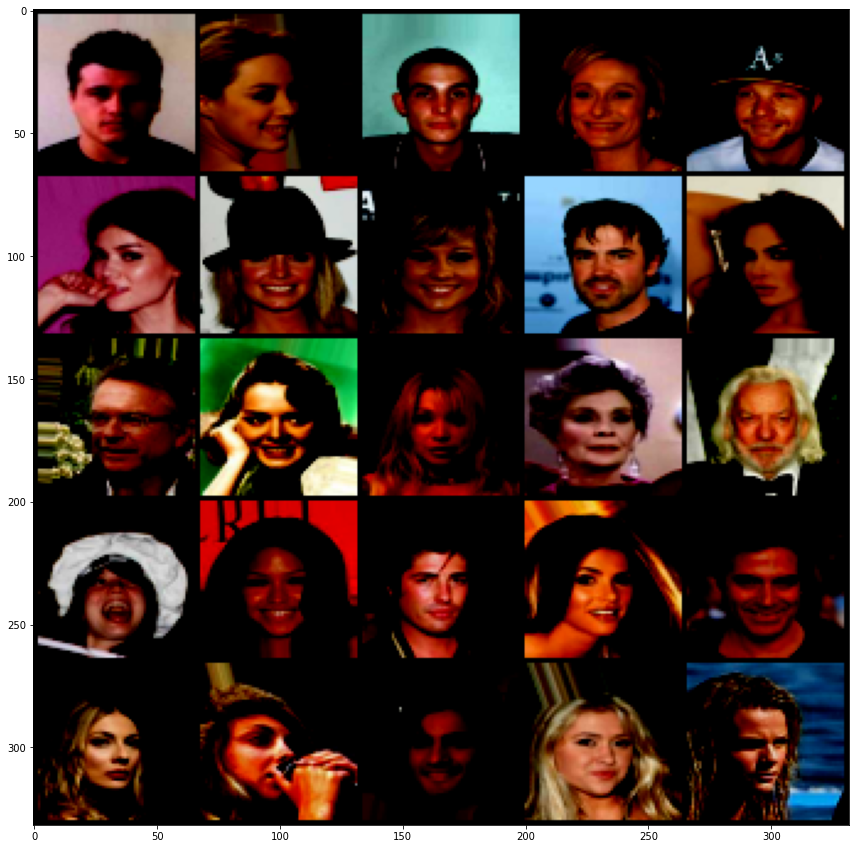

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import PIL
import os

batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Normalize([0.5], [0.5])
])


CELEBA_PATH = "./img_align_celeba/"

class CelebA(torch.utils.data.Dataset):
  def __init__(self, root_path:str, transform: Optional[Callable] = None):
    super().__init__()
    self.transform = transform
    self.root_path = root_path
    self.img_paths = os.listdir(root_path)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx:int):
    img = PIL.Image.open(os.path.join(self.root_path, self.img_paths[idx]))
    if self.transform: img = self.transform(img)
    return img

    


full_dataset = CelebA(CELEBA_PATH, transform=transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=True)

from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([full_dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

In [5]:
len(full_dataset)

202599

# Variational Auto Encoder (VAE)

## Problem

Latent space is not completely covered by standard autoencoders (irregularity problem)

![](https://miro.medium.com/max/1000/1*83S0T8IEJyudR_I5rI9now@2x.png)

## Solution

Lets learn posterior distribution of z given x: $p(z|x)$ instead of pointwise estimation of z

## Problem 2

How to fit $p(z|x)$? Originally we can only make a suggestion about prior $p(z)$ (it can be $\mathcal{N}(0,1)$, for instance)

## Solution 

Lets approximate $p(z|x)$ with neural network $q_x(z)$:

![](https://miro.medium.com/max/700/1*j9goPhh0meH884uGL70Aqg@2x.png)

$q_x(z)$ can be fitted to $p(z|x)$ by KL-divergence minimization:

![](https://miro.medium.com/max/700/1*v56YF5KqZk35r85EZBZuAQ@2x.png)

In [6]:
# The code is taken from https://github.com/ku2482/vae.pytorch
from torch.autograd import Variable

class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        ) 
        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz) 
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    @staticmethod
    def reparametrize(mu, logvar):
        ### return sample from normal distribution using reparametrization trick given MU and LOGVARiance
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mu) 

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Calculate mean and (log)variance
        hidden = self.encoder(inputs).view(batch_size, -1)
        mean, logvar = self.mean(hidden), self.logvar(hidden) 
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden) # reconstructed image
        return output

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device) 
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        ### return sample from normal distribution using reparametrization trick given MU and LOGVARiance
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mu) 

    def sample(self, size):
        # generate random sample z from prior p(z) and pass through the decoder. It will be your new generated sample
        mu, sigma = torch.zeros((size, self.nz)).to(device), torch.ones((size, self.nz)).to(device)
        z = self.reparametrize(mu, sigma)
        dec_output = self.decode(z)
        return dec_output
    
    @property
    def device(self): return next(self.parameters()).device

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Fit VAE
Implement variational autoencoder (VAE)

**Hint 1**:
$$L = \int_zq(z)log(p(x|\Theta,z))dz - KL(q(z)||p(z))$$
**Hint 2**:

$$p(z)=\mathcal{N}(0,1)$$

$$q(z)=\mathcal{N}(\mu_1,\Sigma_1)$$

$\Sigma_1$ is diagonal!

$$\mathcal{D}[\mathcal{N}(\mu_0, \Sigma_0)||\mathcal{N}(\mu_1, \Sigma_1)] = \frac{1}{2}\big(tr(\Sigma_1^{-1}\Sigma_0)+(\mu_1-\mu_0)^T\Sigma_1^{-1}(\mu_1-\mu_0)-k+\log(\frac{\det\Sigma_1}{\det\Sigma_0})\big)$$
(k-dimensionality)


In [7]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    criterion = nn.MSELoss(reduction='sum')
    MSE = criterion(recon_x, x)/batch_size # reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).sum()/batch_size # KL between q(z) and p(z)
    return MSE, KLD

log_interval=10
epochs=10


def train(pbar):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad() 
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        train_mse += mse_loss
        train_kld += kld_loss
        train_loss += loss
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)
    
with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
  for epoch in range(1, epochs + 1):
      train(pbar)
      with torch.no_grad():
          sample = model.sample(64).cpu()
          log_img = make_grid(sample)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[KL: ?] [MSE: ?]:   0%|          | 0/31650 [00:00<?, ?it/s]

In [8]:
def sample(model, size):
      # generate random sample z from prior p(z) and pass through the decoder
      mu, sigma = torch.zeros((size, model.nz)).to(device), torch.ones((size, model.nz)).to(device)
      z = model.reparametrize(mu, sigma)
      dec_output = model.decode(z)
      return dec_output

with torch.no_grad():
    sample = sample(model, 64).cpu()
    log_img = make_grid(sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


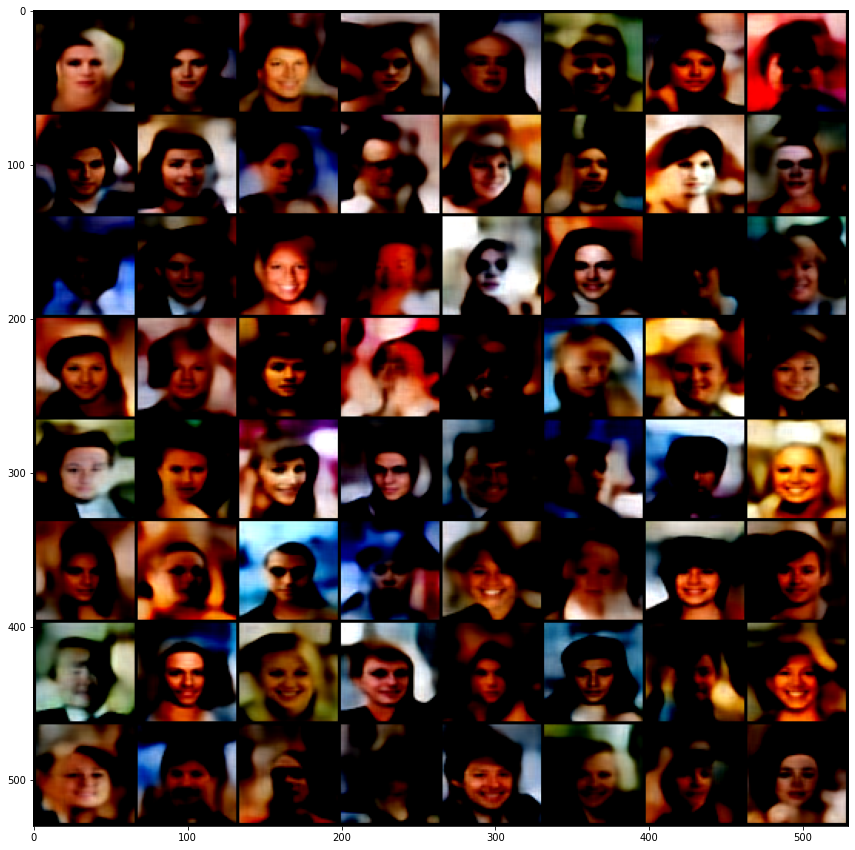

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0))

  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-9bike2su
  Running command git clone -q https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-9bike2su
  Running command git submodule update --init --recursive -q
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4979 sha256=175e5a424b921a3825ccc5b22fa4325cd758addc57ca6b35e91be332a84b4661
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3dls50l/wheels/1e/cf/b5/31d11273e162675221f38043989d970cf7c7c8571d4e8d456d
Failed to build lpips-pytorch
    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

  0%|          | 0/3165 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


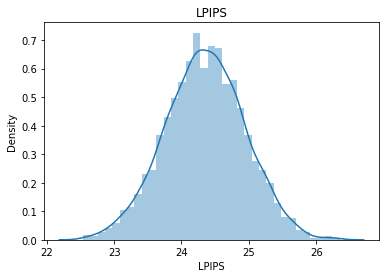

In [11]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

from lpips_pytorch import LPIPS, lpips
from tqdm.notebook import tqdm

# define as a criterion module (recommended)
criterion = LPIPS(
    net_type='alex',  # choose a network type from ['alex', 'squeeze', 'vgg']
    version='0.1'  # Currently, v0.1 is supported
)

dists = []
with torch.no_grad():
  for batch_idx, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        batch_size = data.shape[0]
        sample = model.sample(batch_size).cpu()
        dist = criterion(sample, data).squeeze().item()
        dists.append(dist)
import seaborn as sns

plt.title('LPIPS')
plt.xlabel('LPIPS')
sns.distplot(dists)

In [12]:
np.mean(dists)

24.3502541498362

In [13]:
PATH = '/content/drive/MyDrive/bayes/vae_celeba_model'
torch.save(model.state_dict(), PATH)